In [114]:
import matplotlib.pyplot as plt
import eval7
import numpy as np


In [40]:



# generate all preflop hands
def all_hands():
    deck= eval7.Deck()
    hands = []
    for i in range(52):
        for j in range(i+1, 52):
            hands.append((deck.cards[i], deck.cards[j]))
    return hands

def all_hands_distinct():
    # all pairs, all suited combos, all unsuited combos
    numbers = ["A", "K", "Q", "J", "T", "9", "8", "7", "6", "5", "4", "3", "2"]

    combos = []
    for i in range(len(numbers)):
        combos.append(eval7.HandRange(f"{numbers[i]}{numbers[i]}")) # pocket pairs
        for j in range(i+1, len(numbers)):
            combos.append(eval7.HandRange(f"{numbers[i]}{numbers[j]}s")) # suited combos
            combos.append(eval7.HandRange(f"{numbers[i]}{numbers[j]}o")) # unsuited combos
    return combos

def maximal_range():
    return eval7.HandRange(','.join([hand.string for hand in all_hands_distinct()]))

In [ ]:
def evaluate_hand_monte_carlo(hand):
    if type(hand) == eval7.HandRange:
        strengths = eval7.py_all_hands_vs_range(hand, maximal_range(), [], 10000)
        return sum(strengths.values()) / len(strengths)
    else:
        return eval7.py_hand_vs_range_monte_carlo(eval7.HandRange(hand), maximal_range(), [], 10000)

HAND_STRENGTHS_DISTINCT = {}
for hand in all_hands_distinct():
    HAND_STRENGTHS_DISTINCT[hand.string] = evaluate_hand_monte_carlo(hand)
    
HANDS_DISTINCT_BY_STRENGTH = sorted(HAND_STRENGTHS_DISTINCT.keys(), key=lambda x: HAND_STRENGTHS_DISTINCT[x], reverse=True)


In [86]:
def get_percentile_range(percentile):
    # return a list of all the hands in the top percentile
    return HANDS_DISTINCT_BY_STRENGTH[:int(percentile * len(HANDS_DISTINCT_BY_STRENGTH))]

In [146]:
stack = 3250
villain_stack = 825
hand = [eval7.Card("6h"), eval7.Card("9c")]
pot = 425

sb = 125
bb = 250
ante = 25
players = 2
M = min(stack, villain_stack) / (sb + bb + ante * players)

# semi-bluffing equation: EV = fold% * pot + (1 - fold%) * (win% * pot + (1 - win%) * -call_cost)
# suppose we go all in for his stack amount plus the bb-sb. What are his pot odds?

raise_cost = villain_stack + bb - sb
new_pot = pot + villain_stack
call_cost = villain_stack
pot_odds = call_cost / (new_pot + call_cost)
print(f"Pot: {pot}, call cost: {call_cost}, Pot odds: {pot_odds}")

# so in theory, our villain needs 40% equity to call
# but the fact that we raised preflop means we have a stronger range.
# For now: say our opponent will call with 22+, A2+, JT+

Pot: 425, call cost: 825, Pot odds: 0.39759036144578314
Our Call Equity: 0.3431999981403351
Fold Probability: 0.7239819004524887
Semi bluff equation: (0.7239819004524887) * 425 + (1 - 0.7239819004524887) * (0.3431999981403351 * 1250 + (1 - 0.3431999981403351) * -825)
EV: 276.5409039122756


276.5409039122756

In [166]:
def get_EV_against_call_percentile(hand, call_percentile, pot, call_cost, raise_cost, verbose = False):
    '''
    Find our EV of going all in as the small blind against a calling range percentile, e.g. top 0.1 of hands.
    Villain has to push his call_cost to play on. We have to push his raise_cost (his stack plus the bb-sb) to put him all in.
    '''
    win_amount = pot + call_cost # what we win if he calls and we win
    lose_amount = raise_cost # what we lost if he calls and we lose

    call_range = eval7.HandRange(','.join(get_percentile_range(call_percentile))) 
    equity = eval7.py_hand_vs_range_monte_carlo(hand, call_range, [], 50000) 

    # fold equity now. he calls with anything in this range, so he folds with anything else.
    fold_prob = 1 - (len(call_range) / 1326)

    # now, what is our EV for this raise?
    EV = fold_prob * pot + (1 - fold_prob) * (equity * win_amount - (1-equity) * lose_amount)

    if verbose:
        print(f"Our Hand: {hand}")
        print(f"Call Range: {call_range}")
        print(f"Our Call Equity: {equity}")
        print(f"Fold Probability: {fold_prob}")
        print(f"Semi bluff equation: ({fold_prob}) * {pot} + (1 - {fold_prob}) * ({equity} * {win_amount} + (1 - {equity}) * -{lose_amount})")
        print(f"EV: {EV}")

    return EV

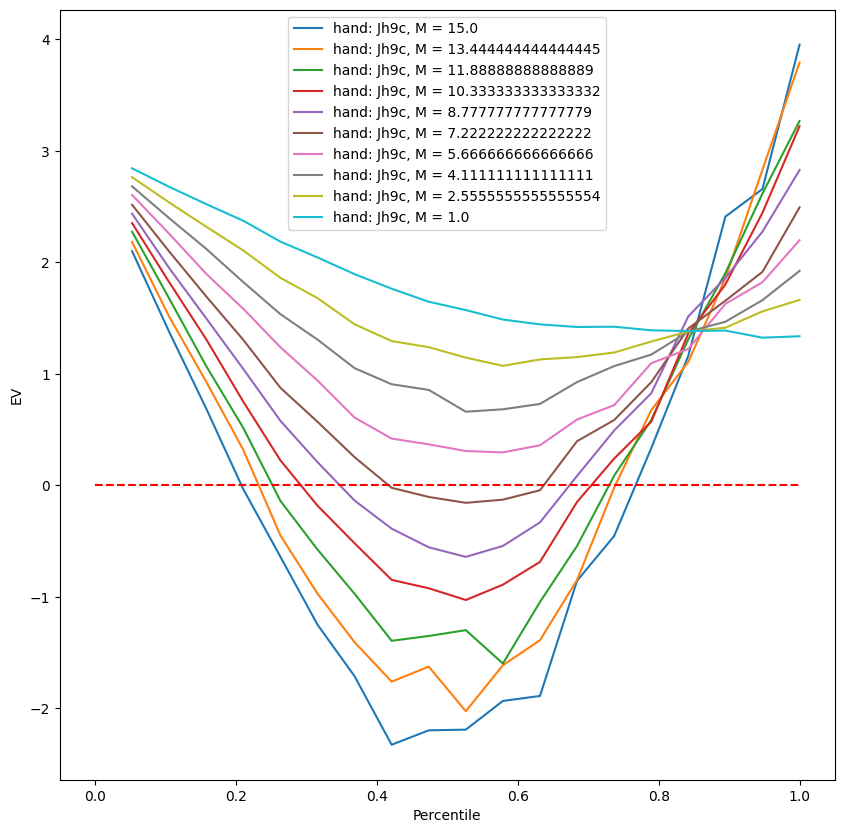

In [201]:
hands = [
    # (eval7.Card("9h"), eval7.Card("Tc")), 
    (eval7.Card("Jh"), eval7.Card("9c")),
    ]
pot = 3

fig = plt.figure(figsize=(10, 10))

for hand in hands: # find the maximum M for each hand such that pushing is profitable, no matter how the opponent plays
    Ms = np.linspace(15, 1, 10)
    for M in Ms:
        villain_stack = M*pot # assume the pot is just blinds
        call_cost = villain_stack
        raise_cost = villain_stack + 1

        # what if our opponent had a different call range, namely any cards with strength above a certain percentile?
        evs = []
        percentiles = np.linspace(0, 1, 20)[1:]
        for p in percentiles:
            evs.append(get_EV_against_call_percentile(hand, p, pot, call_cost, raise_cost))
        # if min(evs) > 0: # this play is profitable no matter how our opponent plays
        #     # graph the percentiles against EVs
        #     plt.plot(percentiles, evs)
            # break
        plt.plot(percentiles, evs, label = f"hand: {hand[0]}{hand[1]}, M = {M}")
        

plt.legend()
plt.hlines(0, 0, 1, colors='r', linestyles='dashed')
plt.xlabel("Percentile")
plt.ylabel("EV")
plt.show()